# A simple autoencoder from scratch using the stable layers of tensorflow

In [1]:
%matplotlib inline
import os
import socket
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def cross_entropy(x_, x, offset=1e-7):
    with tf.name_scope('cross_entropy'):
        x__ = tf.clip_by_value(x_, offset, 1 - offset)
        return -tf.reduce_sum(x * tf.log(x__) + (1 - x) * tf.log(1 - x_), 1)
    
def kl_distance(mu, log_sigma):
    with tf.name_scope('KL_divergence'):
        return -0.5 * tf.reduce_sum(1 + 2 * log_sigma - mu**2 - tf.exp(2 * log_sigma), 1)
        
class VariationalAutoEncoder(object):
    DEFAULTS = {
        "batch_size": 128,
        "learning_rate": 5E-4,
        "dropout": 0.9,
        "lambda_l2_reg": 1E-5,
        "nonlinearity": tf.nn.elu,
        "squashing": tf.nn.sigmoid,
        "regularization": tf.contrib.layers.l2_regularizer,
        "mu": 0,
        "sigma": 1.,
    }
    RESTORE_KEY = "to_restore"
    
    def __init__(self, architecture=[], d_hyperparams={}, log_dir='./log'):
        self.architecture = architecture
        self.__dict__.update(VariationalAutoEncoder.DEFAULTS, **d_hyperparams)
        self.sesh = tf.Session()
        #TODO: decide if load a model or build a new one. For now, build it
        handles = self._build_graph()
        
        # In any case, make a collection of variables that are restore-able
        for handle in handles:
            tf.add_to_collection(VariationalAutoEncoder.RESTORE_KEY, handle)
            
        self.sesh.run(tf.global_variables_initializer())

        
        # Unpack the tuple of handles created by the builder
        (self.x_in, self.z_mean, self.z_log_sigma, self.x_reconstructed, self.z, 
               self.cost, self.global_step, self.train_op, self.merged_summaries) = handles
        
        # Initialize the filewriter and write the graph (tensorboard)
        
        self.writer = tf.summary.FileWriter(log_dir, self.sesh.graph)
        
    def _build_graph(self):
        # The architecture is definded here, using contrib layers
        # Tdodo: implement a compose_layers
        
        regularizer = self.regularization(self.lambda_l2_reg)
        #regularizer = None
        # the encoder
        x_in = tf.placeholder(tf.float32, shape=[None, self.architecture[0]], name='x_in')
        x = tf.layers.dense(x_in, 500, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='enc_0')
        x = tf.layers.dropout(x, rate=self.dropout, name='drop_e0')
        x = tf.layers.dense(x, 500, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='enc_1')
        x = tf.layers.dropout(x, rate=self.dropout, name='drop_e1')
        x = tf.layers.dense(x, 250, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='enc_2')
        x = tf.layers.dropout(x, rate=self.dropout, name='drop_e2')
        x = tf.layers.dense(x, 50, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='enc_3')
        x = tf.layers.dropout(x, rate=self.dropout, name='drop_e3')
#         for i, dim in enumerate(self.architecture[1:-1]):
#             print('Encoder: Creating fully connected layer with sizes: IN {} - SIZE {}'.format(x.shape, dim))
#             x = tf.layers.dense(x_in, dim, activation=self.nonlinearity, name='enc_{}'.format(i))
        
        # the latent space (separate the mean and the sigma)
        z_mean = tf.layers.dense(x, self.architecture[-1], activation=self.nonlinearity, name='z_mean') 
        z_log_sigma = tf.layers.dense(x, self.architecture[-1], activation=self.nonlinearity, name='z_log_sigma')
        print('Creating fully connected latent layers with sizes {}'.format(z_mean.shape))

        # The sample from the latent space with n(0,1)
        # With a little trick. Rathern than sampling N(z_mean, z_sigma), 
        # add a gaussian noise
        eps = tf.random_normal(tf.shape(z_log_sigma), 0, self.sigma, 
                               dtype=tf.float32, name='eps')
        
        z = tf.add(z_mean, eps * tf.exp(z_log_sigma), name='z')
        
        # decoder (from z to x_out)
        h = tf.layers.dense(z, 50, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='dec_{}'.format(3))
        h = tf.layers.dropout(h, rate=self.dropout, name='drop_d3')
        h = tf.layers.dense(h, 250, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='dec_{}'.format(2))
        h = tf.layers.dropout(h, rate=self.dropout, name='drop_d2')
        h = tf.layers.dense(h, 500, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='dec_{}'.format(1))
        h = tf.layers.dropout(h, rate=self.dropout, name='drop_d1')
        h = tf.layers.dense(h, 500, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='dec_{}'.format(0))
        h = tf.layers.dropout(h, rate=self.dropout, name='drop_d0')
#         for i, dim in enumerate(self.architecture[1:-1][::-1]):
#             print('Decoder: Creating fully connected layer with sizes: IN {} - SIZE {}'.format(h.shape, dim))
#             h = tf.layers.dense(h, dim, activation=self.nonlinearity, name='dec_{}'.format(i))
        print('Created decoder layers')
        # final reconstruction with squashing to [0, 1]
        y = tf.layers.dense(h, self.architecture[0], activation=self.squashing, 
                            kernel_regularizer=regularizer,
                            name='decoder')
        y = tf.layers.dropout(y, rate=self.dropout, name='drop_decoder')
        x_reconstructed = tf.identity(y, name='x_reconstructed')
        
        # reconstruction loss: cross-entropy
        rec_loss = cross_entropy(x_reconstructed, x_in)
        
        # KL divergence: information loss btw X and Z representations
        kl_loss = kl_distance(z_mean, z_log_sigma)
        
        # regularization loss
        l2_loss = tf.losses.get_regularization_loss()
        
        with tf.name_scope('cost'):
            cost = tf.reduce_sum(rec_loss + kl_loss, name='vae_cost') + l2_loss
            
        # append to summary
        with tf.name_scope('summaries'):
            with tf.name_scope('loss'):
                tf.summary.scalar('kl_loss', tf.reduce_sum(kl_loss, name='kl_scalar'))
                tf.summary.scalar('rec_loss', tf.reduce_sum(rec_loss, name='rl_scalar'))
                tf.summary.scalar('cost', cost)
                tf.summary.scalar('l2_loss', l2_loss)
                tf.summary.histogram('kl_hist', kl_loss)
                tf.summary.histogram('rec_hist', rec_loss)
        
        print('created all layers')
        # The optimization
        global_step = tf.Variable(0, trainable=False)
        with tf.name_scope('AdamOptimizer'):
            optimizer = tf.train.AdamOptimizer(self.learning_rate)
            # simple optimization
            # train_op = optimizer.minimize(cost, global_step=global_step, name='minimize_cost')
            # With clipped gradients:
            train_vars = tf.trainable_variables()
            grads_and_vars = optimizer.compute_gradients(cost, var_list=train_vars)
            
            clipped = []
            for grad, var in grads_and_vars:
                print('var {}'.format(var))
                print('grad {}'.format(grad))
                # add histograms of gradients, per variable (?)
#                 with tf.name_scope('summaries'):
#                     with tf.name_scope('gradients'):
#                         tf.summary.histogram(grad)
                clipped.append((tf.clip_by_value(grad, -5, 5), var))
            train_op = optimizer.apply_gradients(clipped, global_step=global_step, 
                                                name='minimize_cost')
        
        merged_summaries = tf.summary.merge_all()
        # return tuple of operations
        return(x_in, z_mean, z_log_sigma, x_reconstructed, z, 
               cost, global_step, train_op, merged_summaries)
        
    def encode(self, x):
        feed_dict = {self.x_in: x}
        return self.sesh.run([self.z_mean, self.z_log_sigma], feed_dict=feed_dict)
        
    def decode(self, z):
        feed_dict = {self.z: z}
        return self.sesh.run(self.x_reconstructed, feed_dict=feed_dict)
    
    def vae(self, x):
        feed_dict = {self.x_in: x}
        return self.sesh.run([self.x_reconstructed, self.z, self.z_log_sigma], 
                             feed_dict=feed_dict)
    
    def train(self, X, max_iter=np.inf, max_epochs=np.inf, cross_validate=True, verbose=True):
        try:
            err_train = 0
            
            while True:
                x, _ = X.train.next_batch(self.batch_size)
                feed_dict = {self.x_in: x}
                fetches = [self.x_reconstructed, self.cost, self.global_step, self.train_op]
                x_reconstructed, cost, i, _ = self.sesh.run(fetches, feed_dict=feed_dict)

                err_train += cost
                if i % 10 == 0:  # Record summaries and test-set accuracy
                    summary = self.sesh.run(self.merged_summaries, feed_dict=feed_dict)
                    self.writer.add_summary(summary, i)
                if i%1000 and verbose:
                    print('Round {}, loss {}'.format(i, cost))
                if i>=max_iter or X.train.epochs_completed >= max_epochs:
                    print("final avg cost (@ step {} = epoch {}): {}".format(
                            i, X.train.epochs_completed, err_train / i))
                    try:
                        self.writer.flush()
                        self.writer.close()
                    except(AttributeError):  # not logging
                        continue
                    break
                    
        except KeyboardInterrupt:
            print("final avg cost (@ step {} = epoch {}): {}".format(
                i, X.train.epochs_completed, err_train / i))
            print("------- Training end: {} -------\n".format(now))
            
        

## Use it with the mnist dataset

In [3]:
def load_mnist():
    from tensorflow.examples.tutorials.mnist import input_data
    return input_data.read_data_sets("./mnist_data")

def all_plots(model, mnist):
    if model.architecture[-1] == 2: # only works for 2-D latent
        print("Plotting in latent space...")
        plot_all_in_latent(model, mnist)

        print("Exploring latent...")
        plot.exploreLatent(model, nx=20, ny=20, range_=(-4, 4), outdir=PLOTS_DIR)
        for n in (24, 30, 60, 100):
            plot.exploreLatent(model, nx=n, ny=n, ppf=True, outdir=PLOTS_DIR,
                               name="explore_ppf{}".format(n))

    print("Interpolating...")
    interpolate_digits(model, mnist)

    print("Plotting end-to-end reconstructions...")
    plot_all_end_to_end(model, mnist)

    print("Morphing...")
    morph_numbers(model, mnist, ns=[9,8,7,6,5,4,3,2,1,0])

    print("Plotting 10 MNIST digits...")
    for i in range(10):
        plot.justMNIST(get_mnist(i, mnist), name=str(i), outdir=PLOTS_DIR)

def plot_all_in_latent(model, mnist):
    names = ("train", "validation", "test")
    datasets = (mnist.train, mnist.validation, mnist.test)
    for name, dataset in zip(names, datasets):
        plot.plotInLatent(model, dataset.images, dataset.labels, name=name,
                          outdir=PLOTS_DIR)
        
def interpolate_digits(model, mnist):
    imgs, labels = mnist.train.next_batch(100)
    idxs = np.random.randint(0, imgs.shape[0] - 1, 2)
    mus, _ = model.encode(np.vstack(imgs[i] for i in idxs))
    plot.interpolate(model, *mus, name="interpolate_{}->{}".format(
        *(labels[i] for i in idxs)), outdir=PLOTS_DIR)

def plot_all_end_to_end(model, mnist):
    names = ("train", "validation", "test")
    datasets = (mnist.train, mnist.validation, mnist.test)
    for name, dataset in zip(names, datasets):
        x, _ = dataset.next_batch(10)
        x_reconstructed = model.vae(x)
        plot.plotSubset(model, x, x_reconstructed, n=10, name=name,
                        outdir=PLOTS_DIR)

def morph_numbers(model, mnist, ns=None, n_per_morph=10):
    if not ns:
        import random
        ns = random.sample(range(10), 10) # non-in-place shuffle

    xs = np.squeeze([get_mnist(n, mnist) for n in ns])
    mus, _ = model.encode(xs)
    plot.morph(model, mus, n_per_morph=n_per_morph, outdir=PLOTS_DIR,
               name="morph_{}".format("".join(str(n) for n in ns)))

In [4]:
IMG_DIM = 28

ARCHITECTURE = [IMG_DIM**2, # 784 pixels
                500, 500, # intermediate encoding
                3] # latent space dims
                # 50]
# (and symmetrically back out again)

HYPERPARAMS = {
    "batch_size": 128,
    "learning_rate": 5E-4,
    "dropout": 0.1,
    "lambda_l2_reg": 1E-5,
    "nonlinearity": tf.nn.elu,
    "squashing": tf.nn.sigmoid
}

MAX_ITER = 2000#2**16
MAX_EPOCHS = np.inf

LOG_DIR = "./log"
METAGRAPH_DIR = "./out"
PLOTS_DIR = "./png"



In [5]:
v = VariationalAutoEncoder(ARCHITECTURE, HYPERPARAMS, log_dir=LOG_DIR)
#mnist = load_mnist()
#v.train(mnist, max_iter=MAX_ITER, max_epochs=MAX_EPOCHS, cross_validate=False, verbose=True)

Creating fully connected latent layers with sizes (?, 3)
Created decoder layers
created all layers
var <tf.Variable 'enc_0/kernel:0' shape=(784, 500) dtype=float32_ref>
grad Tensor("AdamOptimizer/gradients/AddN_12:0", shape=(784, 500), dtype=float32)
var <tf.Variable 'enc_0/bias:0' shape=(500,) dtype=float32_ref>
grad Tensor("AdamOptimizer/gradients/enc_0/BiasAdd_grad/tuple/control_dependency_1:0", shape=(500,), dtype=float32)
var <tf.Variable 'enc_1/kernel:0' shape=(500, 500) dtype=float32_ref>
grad Tensor("AdamOptimizer/gradients/AddN_11:0", shape=(500, 500), dtype=float32)
var <tf.Variable 'enc_1/bias:0' shape=(500,) dtype=float32_ref>
grad Tensor("AdamOptimizer/gradients/enc_1/BiasAdd_grad/tuple/control_dependency_1:0", shape=(500,), dtype=float32)
var <tf.Variable 'enc_2/kernel:0' shape=(500, 250) dtype=float32_ref>
grad Tensor("AdamOptimizer/gradients/AddN_10:0", shape=(500, 250), dtype=float32)
var <tf.Variable 'enc_2/bias:0' shape=(250,) dtype=float32_ref>
grad Tensor("AdamOpti

In [6]:
mnist = load_mnist()
v.train(mnist, max_iter=MAX_ITER, max_epochs=MAX_EPOCHS, cross_validate=False, verbose=True)

Extracting ./mnist_data/train-images-idx3-ubyte.gz
Extracting ./mnist_data/train-labels-idx1-ubyte.gz
Extracting ./mnist_data/t10k-images-idx3-ubyte.gz
Extracting ./mnist_data/t10k-labels-idx1-ubyte.gz
Round 1, loss 69724.984375
Round 2, loss 69138.9140625
Round 3, loss 67286.6875
Round 4, loss 64937.84765625
Round 5, loss 61388.12109375
Round 6, loss 56951.83984375
Round 7, loss 51933.80078125
Round 8, loss 46828.4921875
Round 9, loss 42716.54296875
Round 10, loss 39074.328125
Round 11, loss 36745.05078125
Round 12, loss 32576.40625
Round 13, loss 30974.46875
Round 14, loss 29178.376953125
Round 15, loss 28551.859375
Round 16, loss 29144.57421875
Round 17, loss 28964.31640625
Round 18, loss 27348.90625
Round 19, loss 27997.4140625
Round 20, loss 27430.0390625
Round 21, loss 27220.59765625
Round 22, loss 28103.51171875
Round 23, loss 25762.609375
Round 24, loss 27279.359375
Round 25, loss 26889.59375
Round 26, loss 27040.283203125
Round 27, loss 27155.900390625
Round 28, loss 27873.494

Round 296, loss 22251.857421875
Round 297, loss 22461.234375
Round 298, loss 23273.611328125
Round 299, loss 22309.2890625
Round 300, loss 23890.421875
Round 301, loss 22429.51171875
Round 302, loss 22667.43359375
Round 303, loss 22782.96875
Round 304, loss 22615.990234375
Round 305, loss 23009.59375
Round 306, loss 23042.767578125
Round 307, loss 23772.341796875
Round 308, loss 23171.80859375
Round 309, loss 22360.04296875
Round 310, loss 23581.99609375
Round 311, loss 22769.947265625
Round 312, loss 22666.72265625
Round 313, loss 22518.6875
Round 314, loss 23376.45703125
Round 315, loss 22523.697265625
Round 316, loss 22860.5078125
Round 317, loss 22501.857421875
Round 318, loss 23141.32421875
Round 319, loss 21866.708984375
Round 320, loss 23081.80078125
Round 321, loss 21853.98046875
Round 322, loss 23452.505859375
Round 323, loss 22638.9296875
Round 324, loss 22466.5390625
Round 325, loss 23060.1796875
Round 326, loss 22269.783203125
Round 327, loss 22949.587890625
Round 328, loss

Round 590, loss 20769.73046875
Round 591, loss 21271.064453125
Round 592, loss 20329.1875
Round 593, loss 21406.08984375
Round 594, loss 22586.908203125
Round 595, loss 20512.04296875
Round 596, loss 21149.75
Round 597, loss 20990.685546875
Round 598, loss 21941.23046875
Round 599, loss 21205.890625
Round 600, loss 21267.16015625
Round 601, loss 20969.728515625
Round 602, loss 21086.318359375
Round 603, loss 20936.60546875
Round 604, loss 21382.17578125
Round 605, loss 21799.14453125
Round 606, loss 21227.072265625
Round 607, loss 20890.0234375
Round 608, loss 20409.890625
Round 609, loss 21388.310546875
Round 610, loss 22113.3828125
Round 611, loss 21438.08984375
Round 612, loss 21463.37890625
Round 613, loss 21038.560546875
Round 614, loss 20279.41015625
Round 615, loss 20025.29296875
Round 616, loss 21145.53515625
Round 617, loss 20790.263671875
Round 618, loss 21317.69921875
Round 619, loss 20256.48046875
Round 620, loss 21841.013671875
Round 621, loss 21267.201171875
Round 622, lo

Round 860, loss 20422.130859375
Round 861, loss 20375.57421875
Round 862, loss 20137.3828125
Round 863, loss 20720.380859375
Round 864, loss 19622.42578125
Round 865, loss 20696.0703125
Round 866, loss 20745.251953125
Round 867, loss 20585.431640625
Round 868, loss 21056.55859375
Round 869, loss 19918.2421875
Round 870, loss 20772.71484375
Round 871, loss 20379.17578125
Round 872, loss 20039.76953125
Round 873, loss 20700.431640625
Round 874, loss 19995.677734375
Round 875, loss 20452.830078125
Round 876, loss 20819.955078125
Round 877, loss 20327.455078125
Round 878, loss 19981.94140625
Round 879, loss 19992.021484375
Round 880, loss 20414.3984375
Round 881, loss 20675.603515625
Round 882, loss 20270.005859375
Round 883, loss 20695.189453125
Round 884, loss 20846.3984375
Round 885, loss 20747.76171875
Round 886, loss 20438.458984375
Round 887, loss 20213.37890625
Round 888, loss 21185.4765625
Round 889, loss 20361.544921875
Round 890, loss 21362.267578125
Round 891, loss 20135.0996093

Round 1150, loss 20491.60546875
Round 1151, loss 20607.005859375
Round 1152, loss 20165.658203125
Round 1153, loss 20867.50390625
Round 1154, loss 20089.4375
Round 1155, loss 19900.423828125
Round 1156, loss 20757.923828125
Round 1157, loss 20563.056640625
Round 1158, loss 20062.701171875
Round 1159, loss 19183.369140625
Round 1160, loss 20234.376953125
Round 1161, loss 20279.126953125
Round 1162, loss 19658.9140625
Round 1163, loss 20184.732421875
Round 1164, loss 20169.244140625
Round 1165, loss 19619.728515625
Round 1166, loss 19818.044921875
Round 1167, loss 20389.662109375
Round 1168, loss 20421.107421875
Round 1169, loss 21346.072265625
Round 1170, loss 19799.330078125
Round 1171, loss 20985.822265625
Round 1172, loss 19890.05859375
Round 1173, loss 20259.15625
Round 1174, loss 20374.8359375
Round 1175, loss 19667.953125
Round 1176, loss 19555.369140625
Round 1177, loss 19986.779296875
Round 1178, loss 20552.54296875
Round 1179, loss 19998.607421875
Round 1180, loss 19197.9355468

Round 1430, loss 20856.826171875
Round 1431, loss 19389.150390625
Round 1432, loss 19610.275390625
Round 1433, loss 20391.681640625
Round 1434, loss 19774.5078125
Round 1435, loss 20124.744140625
Round 1436, loss 20077.392578125
Round 1437, loss 19455.421875
Round 1438, loss 20166.12109375
Round 1439, loss 20842.26953125
Round 1440, loss 20355.365234375
Round 1441, loss 19973.265625
Round 1442, loss 21011.029296875
Round 1443, loss 18990.853515625
Round 1444, loss 20775.552734375
Round 1445, loss 20748.2578125
Round 1446, loss 20353.12890625
Round 1447, loss 19639.232421875
Round 1448, loss 19806.16015625
Round 1449, loss 20397.71875
Round 1450, loss 20396.974609375
Round 1451, loss 19696.916015625
Round 1452, loss 20137.986328125
Round 1453, loss 18927.884765625
Round 1454, loss 20827.923828125
Round 1455, loss 20238.22265625
Round 1456, loss 20704.685546875
Round 1457, loss 19946.9765625
Round 1458, loss 19923.671875
Round 1459, loss 19815.849609375
Round 1460, loss 20147.6328125
Rou

Round 1710, loss 19107.08203125
Round 1711, loss 18856.369140625
Round 1712, loss 20168.19140625
Round 1713, loss 19079.056640625
Round 1714, loss 19748.337890625
Round 1715, loss 19419.376953125
Round 1716, loss 19877.548828125
Round 1717, loss 19881.734375
Round 1718, loss 20568.80078125
Round 1719, loss 20199.841796875
Round 1720, loss 18606.01171875
Round 1721, loss 18966.36328125
Round 1722, loss 20475.859375
Round 1723, loss 20411.681640625
Round 1724, loss 20431.525390625
Round 1725, loss 19534.001953125
Round 1726, loss 19570.076171875
Round 1727, loss 19586.638671875
Round 1728, loss 18836.35546875
Round 1729, loss 20277.935546875
Round 1730, loss 20365.08984375
Round 1731, loss 19999.341796875
Round 1732, loss 19831.3125
Round 1733, loss 20052.9375
Round 1734, loss 20330.43359375
Round 1735, loss 19277.283203125
Round 1736, loss 19618.990234375
Round 1737, loss 19481.400390625
Round 1738, loss 19476.357421875
Round 1739, loss 20224.859375
Round 1740, loss 19972.572265625
Roun

Round 1988, loss 19637.76953125
Round 1989, loss 20273.015625
Round 1990, loss 20264.80859375
Round 1991, loss 20402.41015625
Round 1992, loss 20531.38671875
Round 1993, loss 19150.94140625
Round 1994, loss 20866.30859375
Round 1995, loss 20361.2578125
Round 1996, loss 19436.791015625
Round 1997, loss 20009.146484375
Round 1998, loss 20572.568359375
Round 1999, loss 18907.771484375
final avg cost (@ step 2000 = epoch 4): 21300.06415234375


In [7]:
xx,yy = mnist.test.next_batch(1000)
xr, zm, zs = v.vae(xx)

In [8]:
xx.shape

(1000, 784)

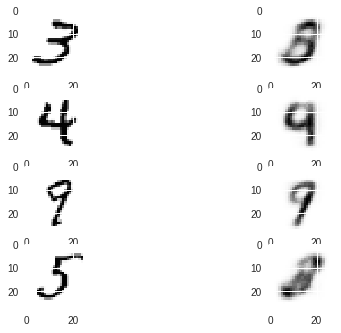

In [9]:
examples_plot = [0, 4, 6, 10]

for i, j in enumerate(examples_plot):
    plt.subplot(len(examples_plot), 2, (i+1)*2-1)
    plt.imshow(xx[j].reshape(28, 28))
    plt.subplot(len(examples_plot), 2, (i+1)*2)
    plt.imshow(xr[j].reshape(28, 28))

In [10]:
reconstruction = pd.DataFrame(np.c_[zm, yy], columns=['e1', 'e2', 'e3', 'd'])

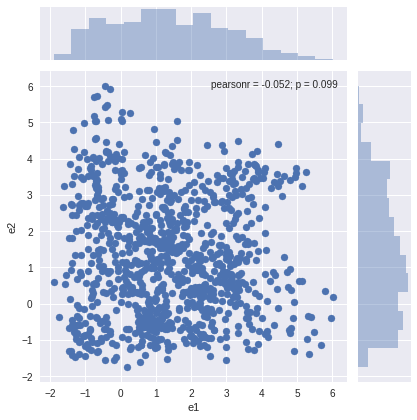

In [11]:
sns.jointplot(x="e1", y="e2", data=reconstruction);

/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


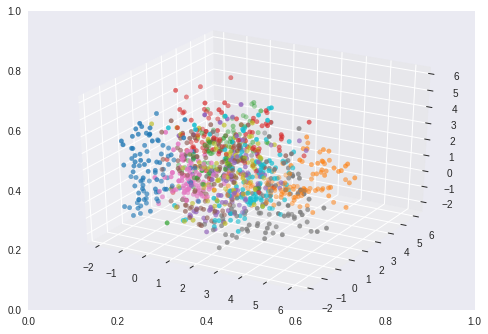

In [18]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, axisbg="1.0")
ax = fig.gca(projection='3d')

ax.scatter(reconstruction['e1'], reconstruction['e2'], reconstruction['e3'], 
            c=reconstruction['d'], 
            cmap = 'tab10')

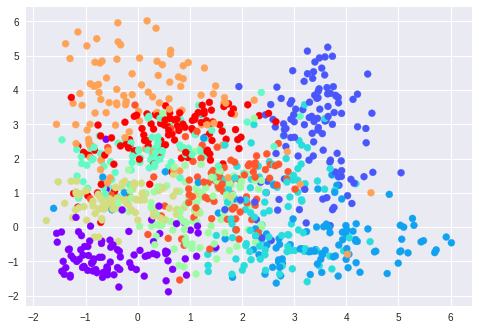

In [13]:
kwargs={}
classes = set(yy)
colormap = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
kwargs['c'] = [colormap[i] for i in yy]
plt.scatter(zm[:,1], zm[:,0], **kwargs)

In [14]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette())

In [15]:
cmap